In [2]:
import networkx as nx
import numpy as np
import pandas as pd
import statistics as st
import pickle
import os
import matplotlib
import matplotlib.pyplot as plt
from sklearn.mixture import BayesianGaussianMixture
from scipy.stats import hypergeom
import scanpy as sc

os.chdir(r'C:\Users\harsh\OneDrive\Desktop\2nd Sem\Computational Genomics\Project')

<h1>Loading all the Datasets</h1>

In [3]:
# Load data (deserialize)
with open('intermediate_results.pickle', 'rb') as handle:
    intermediate_results = pickle.load(handle)

In [4]:
#Unpacking all the files to appropriate namespaces
M=intermediate_results[0]
A=intermediate_results[1]
B=intermediate_results[2]
ad=intermediate_results[3]
labels=intermediate_results[4]
weights=intermediate_results[5]
SEACell_ad=intermediate_results[6]
SEACell_soft_ad=intermediate_results[7]

In [5]:
#Creating MB
MB=M @ B
MB = MB.T

print(np.shape(MB))

(90, 6881)


In [6]:
# Load data (deserialize) The dictionaries
with open('edge_metacell_dicts.pickle', 'rb') as handle:
    edge_metacell_dicts = pickle.load(handle)

In [7]:
edged=edge_metacell_dicts[0]
metacellsd=edge_metacell_dicts[1]

In [8]:
#Creating new Edge Dict with Edge name as 'Keys'
edge_dict={}
for i in range(len(edged)):
    edge_dict.update({edged.get(i)[1][0]+'_'+edged.get(i)[1][1]: edged.get(i)[0]})

In [9]:
# Load data (deserialize) The dictionaries
with open('celld.pickle', 'rb') as handle:
    celld = pickle.load(handle)

# ELEMENTS of celld  seacell_assignment, projection_assignment(which edge), position, t_distances(how far is it from that edge), weights, max_weight

In [10]:
#converting celld to a dictionary of dictionaries

for i in celld.keys():
    celld[i]={
        "seacell_assignment": celld.get(i)[0],
        "edge_assignment": celld.get(i)[1],
        "position": celld.get(i)[2],
        "t_distances": celld.get(i)[3],
        "weights": celld.get(i)[4],
        "max_weight": celld.get(i)[5]
    }

In [11]:
# Load data (deserialize) The dictionaries
with open('gene_scores.pickle', 'rb') as handle:
    gene_scores = pickle.load(handle)

In [12]:
#The rna_ad with the highly variable genes annotated 

# Load data (deserialize) The dictionaries
with open('rna_ad.pickle', 'rb') as handle:
    rna_ad = pickle.load(handle)

<h1>Analysis</h1>

In [14]:
highly_var_gene_scores=gene_scores[rna_ad.var[rna_ad.var['highly_variable']].index]

In [68]:
highly_var_gene_scores.shape

(90, 1500)

<h1>delta GENE SCORE FOR EACH PAIR</h1>

In [ ]:
# Lets write some code for pairwise analysis..I am ssuming this gene score stuff is 
#normalised so I can do comparisions(without any major considerations for now)

#gene_scores.index

#The del score is metacell1-metacell2(whatever appears in the pair first)
metacell_pairwise_del_score= pd.DataFrame(columns=['metacell_pair']+list(highly_var_gene_scores.columns))

for i in range(highly_var_gene_scores.shape[0]):
    if i%25==0:
        print(i)
    for j in range(i+1,highly_var_gene_scores.shape[0]):
        #Naming the pair, by simple concatenation (this could be the index of my new dataframe, but keeping it simple for now)
        if int(highly_var_gene_scores.index[i][8:])<int(highly_var_gene_scores.index[j][8:]):      
            metacell_pair=highly_var_gene_scores.index[i]+'_'+highly_var_gene_scores.index[j]
            delta_pair= highly_var_gene_scores.iloc[i,:]-highly_var_gene_scores.iloc[j,:]
        else:
            metacell_pair=highly_var_gene_scores.index[j]+'_'+highly_var_gene_scores.index[i]
            delta_pair= highly_var_gene_scores.iloc[j,:]-highly_var_gene_scores.iloc[i,:]
        
        metacell_pairwise_del_score.loc[len(metacell_pairwise_del_score)] = [metacell_pair]+list(delta_pair)

print(metacell_pairwise_del_score.shape)

In [114]:
#Lets add edge_distances to the above Dataframe

edge_distances=[]

for i in list(metacell_pairwise_del_score['metacell_pair']):
    edge_distances.append(edge_dict[i])
    

metacell_pairwise_del_score=metacell_pairwise_del_score.assign(edge_distances=edge_distances)


In [115]:
#SAVING

import pickle

your_data = metacell_pairwise_del_score

# Store data (serialize)
with open('metacell_pairwise_del_score_highly_var.pickle', 'wb') as handle:
    pickle.dump(your_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [16]:
#Loading
# Load data (deserialize)
with open('metacell_pairwise_del_score_highly_var.pickle', 'rb') as handle:
    metacell_pairwise_del_score = pickle.load(handle)


In [17]:
#For each pair what are the top 5 max differences(absolute value wise)

max5_delta= pd.DataFrame(columns=['Max1_delscore','Max2_delscore','Max3_delscore','Max4_delscore','Max5_delscore','Dist_metacells'])

for i in range(metacell_pairwise_del_score.shape[0]):
    
    x=np.array(abs(metacell_pairwise_del_score.iloc[i,1:1501]))
    x.sort()
    Max5_delscore,Max4_delscore,Max3_delscore,Max2_delscore,Max1_delscore=x[-5:]

    #Distance between this Metacell Pair
    Dist_metacells=metacell_pairwise_del_score.iloc[i,1501]

    #Now let me add the row corresponding to M1,M2 to the metacell_pairwise_del_score dataframe
    max5_delta.loc[i] = [Max5_delscore,Max4_delscore,Max3_delscore,Max2_delscore,Max1_delscore,Dist_metacells]

print(max5_delta.shape)


(4005, 6)


In [18]:
max5_delta.corr()

,Max1_delscore,Max2_delscore,Max3_delscore,Max4_delscore,Max5_delscore,Dist_metacells
Max1_delscore,1.000000,0.981878,0.955218,0.904106,0.767278,0.341972
Max2_delscore,0.981878,1.000000,0.972444,0.919900,0.779594,0.335939
Max3_delscore,0.955218,0.972444,1.000000,0.944301,0.797617,0.326872
Max4_delscore,0.904106,0.919900,0.944301,1.000000,0.839357,0.314274
Max5_delscore,0.767278,0.779594,0.797617,0.839357,1.000000,0.285024
Dist_metacells,0.341972,0.335939,0.326872,0.314274,0.285024,1.000000


In [22]:
metacell_pairwise_del_score.head

<bound method NDFrame.head of               metacell_pair    PRDM16      PER3     SPSB1  SLC25A33     KIF1B   
0     SEACell-46_SEACell-85 -0.215878 -0.408127 -0.229047 -0.024535 -0.024000  \
1     SEACell-46_SEACell-52 -0.553418 -0.245924 -0.226452  0.175385 -0.046789   
2     SEACell-10_SEACell-46  0.469821  0.240574  0.169551  0.195303  0.053141   
3     SEACell-23_SEACell-46 -0.385340 -0.036086 -0.145002  0.465299 -0.113034   
4     SEACell-11_SEACell-46  0.024755  0.350980  0.585096  0.452992  0.129275   
...                     ...       ...       ...       ...       ...       ...   
4000  SEACell-17_SEACell-38 -0.869844  0.000000 -0.024077  0.444152 -0.026869   
4001  SEACell-17_SEACell-57  1.034152 -0.390307  0.434346  0.276304 -0.019421   
4002  SEACell-38_SEACell-61  0.913927 -0.282013  0.466764  0.093328  0.169226   
4003  SEACell-57_SEACell-61 -0.990069  0.108294  0.008341  0.261176  0.161777   
4004  SEACell-38_SEACell-57  1.903996 -0.390307  0.458423 -0.167848  0.007449  

In [42]:
#For each Pair selct genes that differ the most (greater than 1.2)

pair1=np.array(metacell_pairwise_del_score.iloc[22,1:])
pair1=np.absolute(pair1)


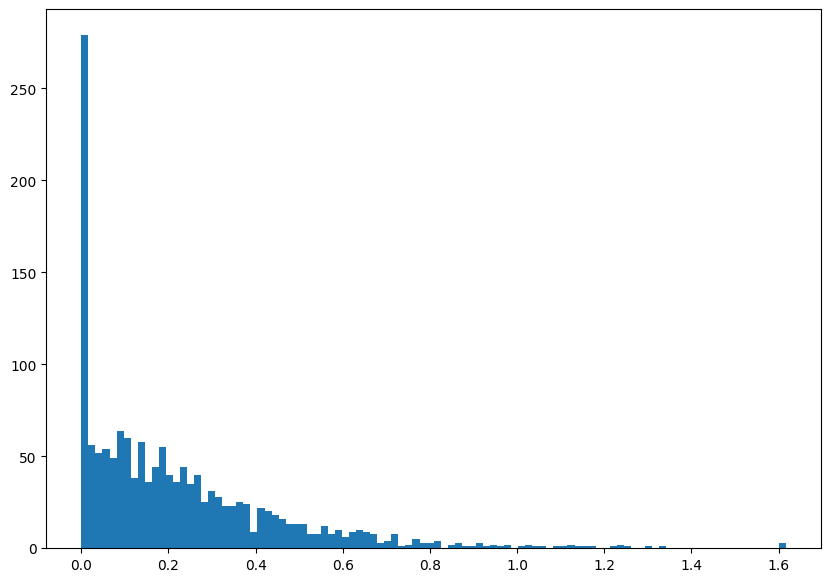

In [43]:
# Distribution of the EDGE LENGTHS 
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(pair1, bins = 100)
 
# Show plot
plt.show()
plt.close()

In [46]:
pair1[pair1>1.2]

metacell_pairwise_del_score.columns[1:]

array([1.2330154824176343, 1.251849056771107, 1.297975928375802,
       1.3386292986697859, 1.616677052456125, 1.2421036445070397,
       1.2238051699270107, 1.6054844319029833, 1.6123118589447905],
      dtype=object)

In [19]:
pair_gene_score_diff={}

for i in range(metacell_pairwise_del_score.shape[0]):
    pair1 = np.array(metacell_pairwise_del_score.iloc[i,1:])
    pair1 = np.absolute(pair1)
    
    score_diff = pair1[pair1>1.2]
    genes = metacell_pairwise_del_score.columns[1:][pair1>1.2]
    
    pair_gene_score_diff[metacell_pairwise_del_score.iloc[i,0]]={'score_diff':score_diff,
                                                                'genes':genes}    


    
    

In [20]:
sig_gene_diff=[]
for i in metacell_pairwise_del_score.iloc[:,0]:
    sig_gene_diff.append(len(pair_gene_score_diff[i]['genes']))
    

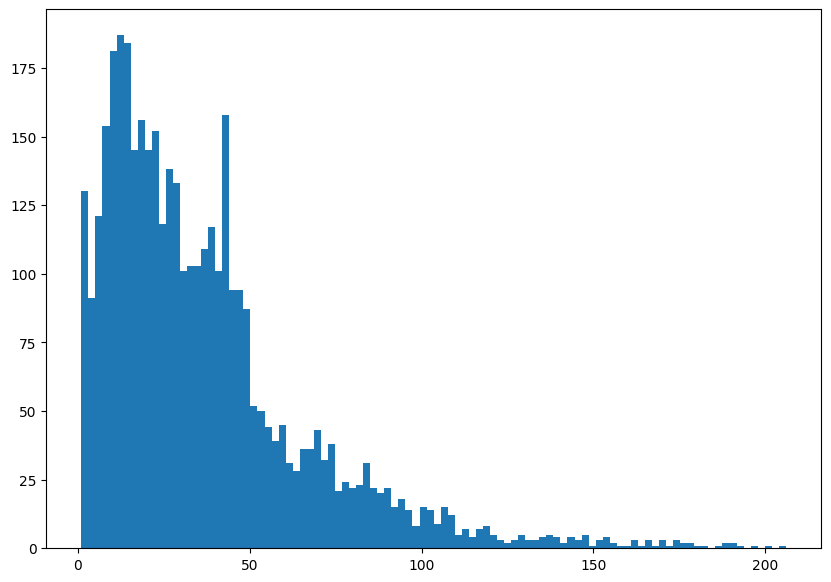

In [21]:
# Distribution of the EDGE LENGTHS 
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(np.array(sig_gene_diff), bins = 100)
 
# Show plot
plt.show()
plt.close()

In [69]:
#Let's run the hypergeometric Test

#The pairwise hypergeometric test (This takes time) save the result

hyper_geom_test_matrix=np.ones((metacell_pairwise_del_score.shape[0],metacell_pairwise_del_score.shape[0]))

for i in range(metacell_pairwise_del_score.shape[0]):
    print(i)
    for j in range(i+1,metacell_pairwise_del_score.shape[0]):
        
        M=metacell_pairwise_del_score.shape[1]-2
        n=len(pair_gene_score_diff[list(pair_gene_score_diff.keys())[i]]['genes'])         
        N=len(pair_gene_score_diff[list(pair_gene_score_diff.keys())[j]]['genes'])       
        x=len(set(pair_gene_score_diff[list(pair_gene_score_diff.keys())[i]]['genes']).intersection(set(pair_gene_score_diff[list(pair_gene_score_diff.keys())[j]]['genes'])))
        
        if x>2:
            hyper_geom_test_matrix[i,j]=1-hypergeom.cdf(x-1, M, n, N)
            hyper_geom_test_matrix[j,i]=hyper_geom_test_matrix[i,j]




0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [70]:
#Saving the hypergeometrix matrix

import pickle

your_data = hyper_geom_test_matrix

# Store data (serialize)
with open('hyper_geom_test_matrix_del_score.pickle', 'wb') as handle:
    pickle.dump(your_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

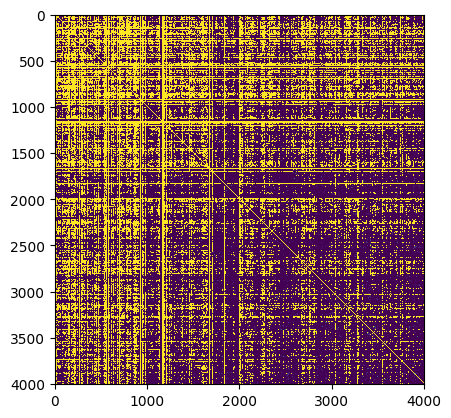

In [71]:
plt.imshow(hyper_geom_test_matrix, interpolation='none')
plt.show()

In [23]:
equal_gene_set=np.ones((metacell_pairwise_del_score.shape[0],metacell_pairwise_del_score.shape[0]))

for i in range(metacell_pairwise_del_score.shape[0]):
    print(i)
    for j in range(i+1,metacell_pairwise_del_score.shape[0]):
        
        n=len(pair_gene_score_diff[list(pair_gene_score_diff.keys())[i]]['genes'])         
        N=len(pair_gene_score_diff[list(pair_gene_score_diff.keys())[j]]['genes'])       
        x=len(set(pair_gene_score_diff[list(pair_gene_score_diff.keys())[i]]['genes']).intersection(set(pair_gene_score_diff[list(pair_gene_score_diff.keys())[j]]['genes'])))
        
        if (x==N) & (x==n):
            equal_gene_set[i,j]=0
            equal_gene_set[j,i]=0
            


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

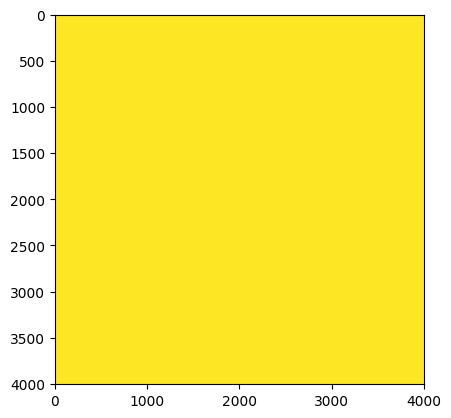

In [24]:
plt.imshow(equal_gene_set, interpolation='none')
plt.show()

In [38]:
len(np.argwhere(equal_gene_set==0))/2

642.0